# SIB KAGGLE PROJECT

In [271]:
#Imports
from utils.func import *
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn import preprocessing 
from sgt import SGT
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils.kmers import KMer_prot
from sklearn.preprocessing import StandardScaler
from propy import PyPro
from sklearn.decomposition import PCA

In [244]:
#First lets see the data!
#Train dataframe
train = pd.read_csv("/Users/André Silva/SIB_G4/Data/train.csv")
#Test dataframe
test = pd.read_csv("/Users/André Silva/SIB_G4/Data/test.csv")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print(f"Labels: {[labels for labels in train.columns]}")
print("Remove data_source")
train= train.drop(columns="data_source")
test= test.drop(columns="data_source")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print("We want to predict tm values for test data")
print(train.describe())

Train data is divided in 31390 lines and 5 col
Test data is divided in 2413 lines and 4 col
Labels: ['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm']
Remove data_source
Train data is divided in 31390 lines and 4 col
Test data is divided in 2413 lines and 3 col
We want to predict tm values for test data
             seq_id            pH            tm
count  31390.000000  31104.000000  31390.000000
mean   15694.500000      6.892339     49.147337
std     9061.656811      1.612225     14.010089
min        0.000000      1.990000     -1.000000
25%     7847.250000      7.000000     42.100000
50%    15694.500000      7.000000     48.000000
75%    23541.750000      7.000000     53.800000
max    31389.000000     64.900000    130.000000


In [245]:
update_train= pd.read_csv("/Users/André Silva/SIB_G4/Data/train_updates_20220929.csv",index_col="seq_id")
train= swap_ph_tm(train,update_train)

In [246]:
train

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [247]:
print(train.isnull().sum().sort_values(ascending=False))
print(test.isnull().sum().sort_values(ascending=False))
#There are some missing values in train
#Data_source values are not that important

pH                  286
seq_id                0
protein_sequence      0
tm                    0
dtype: int64
seq_id              0
protein_sequence    0
pH                  0
dtype: int64


In [248]:
missing_data= train[train["pH"].isnull()]
missing_data

,seq_id,protein_sequence,pH,tm
484,484,ARINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,NaN,84.0
6215,6215,MASHKLLVTPLKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,73.8
6216,6216,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,85.5
6217,6217,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,67.1
6218,6218,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,83.2
...,...,...,...,...
28753,28753,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,58.9
28754,28754,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,59.4
28755,28755,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,57.8
28756,28756,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,59.3


In [249]:
train= train.drop((missing_data).index).reset_index(drop=True)
train
#Podemos remover também a data_source? Não deve de trazer nada de relevante para a analise dos dados

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
28690,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
28691,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
28692,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
28693,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [250]:
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print(f"Labels: {[labels for labels in train.columns]}")

Train data is divided in 28695 lines and 4 col
Test data is divided in 2413 lines and 3 col
Labels: ['seq_id', 'protein_sequence', 'pH', 'tm']


In [251]:
train.describe()

,seq_id,pH,tm
count,28695.000000,28695.000000,28695.000000
mean,15631.432166,6.872467,51.385604
std,9235.099078,0.793184,12.076609
min,0.000000,1.990000,25.100000
25%,7447.500000,7.000000,43.700000
50%,15443.000000,7.000000,48.800000
75%,23758.500000,7.000000,54.600000
max,31389.000000,11.000000,130.000000


Next we will perform an unsupervised analysis of our data
For that we will need to obtain descriptors for our protein sequences 

In [253]:
train_array= np.array(train.loc[:,["protein_sequence"]])
len(train_array)

28695

In [254]:
# kmer = KMer_prot()
# new_data = kmer.fit_transform(train_array)

In [255]:
# new_data= StandardScaler().fit_transform(new_data)
# new_data_mean= [np.mean(line) for line in new_data]
# print("There is a maximum of :",max(new_data_mean))
# print("There is a Minimum of :",min(new_data_mean))

In [256]:
# train["protein_descriptor"] = new_data_mean

In [257]:
di_peptide= CalculateDipeptideComposition(train_array)

In [258]:
di_dataframe= pd.DataFrame(di_peptide)

In [259]:
di_dataframe

,AA,AR,AN,AD,AC,AE,AQ,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
0,2.35,0.88,0.29,0.29,0.00,0.59,0.59,1.18,0.00,0.59,...,0.88,0.29,0.00,0.29,0.59,0.29,1.18,0.00,0.29,1.76
1,0.70,0.70,0.35,0.35,0.00,1.40,2.46,0.70,0.00,0.35,...,0.35,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.70
2,1.21,0.20,0.40,0.60,0.00,0.60,0.60,1.61,0.20,0.20,...,0.40,0.20,0.40,0.00,0.60,0.40,0.40,0.00,0.20,0.20
3,0.38,0.38,0.00,0.76,0.38,0.76,0.38,0.76,0.00,0.38,...,0.38,0.38,0.00,0.00,0.38,0.38,0.76,0.00,0.00,0.38
4,0.28,0.14,0.34,0.28,0.07,0.34,0.34,0.41,0.34,0.34,...,0.34,0.48,0.21,0.28,0.62,0.55,0.83,0.00,0.14,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28690,0.73,0.73,0.00,0.55,0.00,0.36,0.36,0.73,0.00,0.00,...,0.55,0.18,0.18,0.55,0.55,0.36,0.00,0.55,0.18,0.91
28691,1.07,0.21,0.85,0.64,0.00,0.43,0.21,0.85,0.43,0.64,...,0.64,0.43,0.21,0.21,0.21,0.43,0.00,0.00,0.21,0.85
28692,0.79,0.00,1.57,0.00,0.00,1.57,0.79,0.79,1.57,0.79,...,0.79,0.79,0.00,0.00,0.79,0.00,0.79,0.00,0.00,0.79
28693,1.01,0.68,0.00,0.34,0.00,0.51,0.17,0.68,0.17,0.84,...,1.01,0.34,0.34,0.51,0.17,0.84,0.34,0.00,0.17,1.01


In [260]:
molecular_weight = Calculate_molecular_weight(train_array)
isoelectric_point = Calculate_isoelectric_point(train_array)
aromaticity = Calculate_aromaticity(train_array)
instability_index = Calculate_instability_index(train_array)

In [261]:
train["molecular_weight"]=molecular_weight
train["isoelectric_point"]=isoelectric_point
train["aromaticity"]=aromaticity
train["instability_index"]=instability_index

In [262]:
train["pH"]

0        7.0
1        7.0
2        7.0
3        7.0
4        7.0
        ... 
28690    7.0
28691    7.0
28692    7.0
28693    7.0
28694    7.0
Name: pH, Length: 28695, dtype: float64

In [269]:
train_dataset = train.join(di_dataframe)
train_dataset= train_dataset.drop(columns=["tm"])#.drop(columns=["protein_sequence"]).drop(columns=["seq_id"])
train_dataset.sample()

,seq_id,protein_sequence,pH,molecular_weight,isoelectric_point,aromaticity,instability_index,AA,AR,AN,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
10162,10694,MFQQLAARLQEAIDRLRGRGRITEEDLKGTLREIRRALIEADVNLE...,7.0,48134.221,9.78232,0.04157,41.12358,1.39,1.39,0.0,...,2.08,0.23,0.0,0.0,0.23,0.23,0.46,0.23,0.23,0.23


In [266]:
train_y= train["tm"]
train_y

0        75.7
1        50.5
2        40.5
3        47.2
4        49.5
         ... 
28690    51.8
28691    37.2
28692    64.6
28693    50.7
28694    37.6
Name: tm, Length: 28695, dtype: float64

In [274]:
corpus= train_dataset.copy()
corpus['protein_sequence'] = corpus['protein_sequence'].map(list)
#corpus.set_index('id', inplace=True)
corpus = corpus [['seq_id', 'protein_sequence']]
# change index column name becuase otherwise SGT does not work
corpus.columns = ['id', 'sequence']
corpus.sample(1)

,id,sequence
21334,23571,"[M, S, E, P, V, I, K, S, L, L, D, T, D, M, Y, ..."


In [276]:
sgt = SGT(kappa=1, 
           lengthsensitive=False, 
           mode='multiprocessing')
embeddings = sgt.fit_transform(corpus)
embeddings.sample()

embeddings['id'] = embeddings['id'].astype('int32')
embeddings.sample()

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
20610,22767,0.003061,0.000971,0.002625,0.002509,0.001626,0.001176,0.015469,0.002102,0.012541,...,0.006154,0.008415,0.000006,0.000023,0.022851,0.007942,0.013914,0.000301,1.385881e-07,3.329054e-07


In [200]:

pre_processed_data = preprocessing.scale(train_dataset)

print("Media global: ", pre_processed_data.mean())
print("Desvio padrao global: ", pre_processed_data.std())
print("\nVerificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.")
print("\tMédia:", ((pre_processed_data.mean(axis=0) < 0.000001) & (pre_processed_data.mean(axis=0) > -0.000001)).all())
print("\tDesvio Padrão:", ((pre_processed_data.std(axis=0) < 1.000001) & (pre_processed_data.std(axis=0) > 0.999999)).all())

Media global:  -4.803197298218468e-18
Desvio padrao global:  1.0000000000000002

Verificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.
	Média: True
	Desvio Padrão: True


In [201]:
num_test = int(pre_processed_data.shape[0] * 0.5)

print("Numero de exemplos para teste: ", num_test)

indices = np.random.permutation(len(train_dataset))

# Get the Input data pre-processed according with the indexes
train_input = pre_processed_data[indices[1:-num_test]]
test_input = pre_processed_data[indices[-num_test:]]

# Get the output data according with the indexes
train_output = train_y[indices[1:-num_test]]
test_output = train_y[indices[-num_test:]]

Numero de exemplos para teste:  14347


# Unsupervised machine learning

# PCA

[0.03420232 0.02436656 0.02147971 0.01816462 0.01661    0.0146259
 0.01373552 0.0131678  0.01197574 0.01111917 0.01088909 0.01044854
 0.0096601  0.0089777  0.00861417]


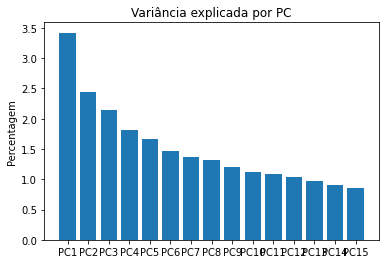

In [279]:
n=15

pca_train= PCA(n_components=n)
pca_train.fit_transform(train_input)

print(pca_train.explained_variance_ratio_)

plt.bar(range(n), pca_train.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.show()


0.22802894680734412
91.65658883183829


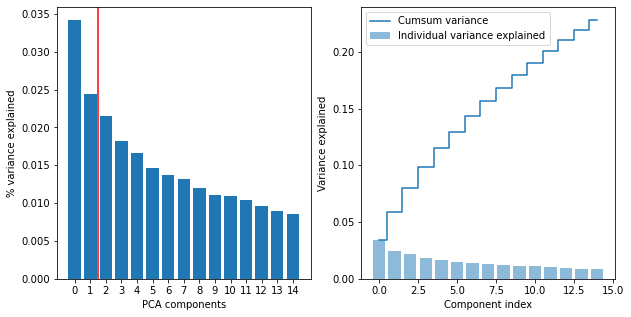

In [277]:
n=15
pca = PCA(n_components=n)

X = pca.fit_transform(train_input)
print(np.sum(pca.explained_variance_ratio_))
print(np.sum(pca.explained_variance_))
df_pca = pd.DataFrame(data=X)

features = range(pca.n_components_)
# кумулятивная сумма союственных векторов, поможет визуализировать объясняемую компонентами дисперсию
exp_var_pca = pca.explained_variance_ratio_
cumsum = np.cumsum(exp_var_pca)   
explained_variance = pca.explained_variance_

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(features, pca.explained_variance_ratio_)
ax[0].set_xlabel('PCA components')
ax[0].set_ylabel('% variance explained')
ax[0].set_xticks(features)
ax[0].axvline(x=1.5, c='r')

ax[1].bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual variance explained')
ax[1].step(range(0,len(cumsum)), cumsum, where='mid',label='Cumsum variance')
ax[1].set_ylabel('Variance explained')
ax[1].set_xlabel('Component index')
ax[1].legend(loc='best')

### K-Means

K-Means is a unsupervised machine learning algorithm used to group data into clusters based on similarities.
The goal of K-means is to partition a dataset into a specified number of clusters (k) in a way that minimizes the within-cluster sum of squares. Here we present the following steps to run this algotithm:

1. Randomly selecting k initial centroids (points in the dataset that represent the center of the clusters)
2. Data point assigned to the cluster corresponding to the nearest centroid
3. The centroids are then updated to be the mean of the points in their respective clusters

This process is repeated until the centroids no longer change, or a maximum number of iterations is reached (In this case we set a maximum number of iterations)

In [203]:
ph_array=train_input[:, 0]
train_input= train_input[:, 1:]
test_input= test_input[:, 1:]

In [222]:
len(train_input[0])


404

In [223]:
len(test_input[0])

404

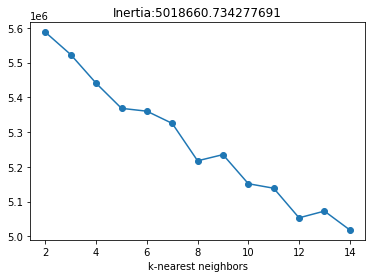

In [242]:
k=list(range(2,15))
ssd=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(train_input)
    ssd.append(kmeans.inertia_)
    
plt.plot(k, ssd, 'o-')
plt.xlabel('k-nearest neighbors')
#plt.ylabel('Sum of squared error')
ii=kmeans.inertia_
plt.title('Inertia:{}'.format(ii))
plt.show()

In [238]:
kmeans_train= KMeans(n_clusters=k,max_iter=1000).fit(train_input)
kmeans_result=kmeans_train.predict(test_input)
inertia=kmeans_train.inertia_

5040241.403022012

In [232]:
centroids= kmeans_train.cluster_centers_
labels= kmeans_train.labels_

In [225]:
print(len(ph_array))
print(len(train_input))

14347
14347


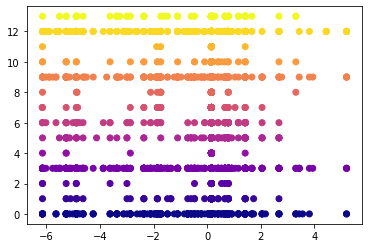

In [227]:
plt.scatter(ph_array, kmeans_result, c=kmeans_result, cmap='plasma')


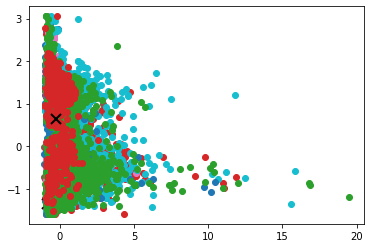

In [235]:
for i in range(k):
    # select only data observations with cluster label == i
    ds = train_input[np.where(labels==i)]
    # plot the data observations (only 2 first colums)
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=10.0)    # x size 
    plt.setp(lines,mew=2.0)    #grossura da linha
plt.show()

In [110]:
kmeans_test = kmeans_train.predict(test_input)

In [112]:
pd.crosstab(labels, kmeans_test)

col_0,0,1,2
row_0,,,
0,1427,99,2926
1,137,8,212
2,2967,244,6327


# t-SNE

In [138]:
from sklearn.manifold import TSNE

In [139]:
tsne = TSNE(n_components=2, n_iter=1000,perplexity=40)
points = tsne.fit_transform(train_input)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


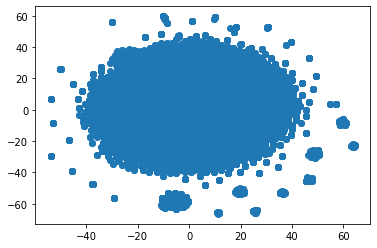

In [140]:
plt.scatter(points[:,0],points[:,1])

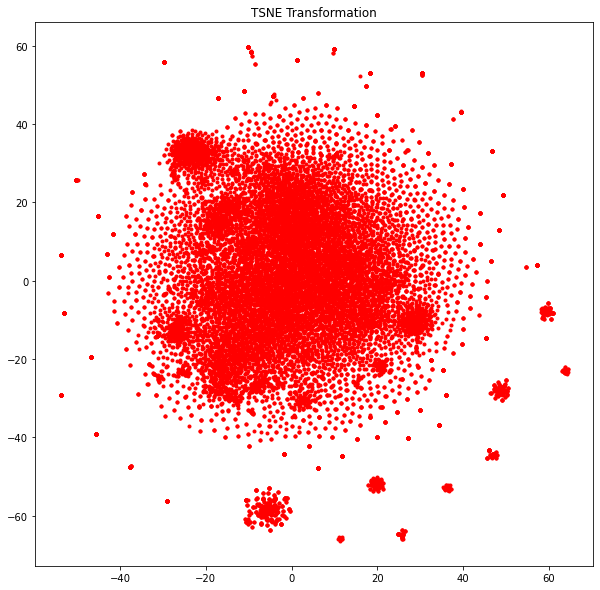

<Figure size 432x288 with 0 Axes>

In [281]:
plt.figure(figsize=(10,10))
plt.plot(points[:,0], points[:,1], 'r.')
plt.title('TSNE Transformation')
plt.show()
plt.savefig('creature.png') 